## DSE 200 Matplotlib Extras

Creating custom visualizations for your data. Here, we create radial plots that represent how many standard deviations away from the mean a given sample is. 

The radial plot code was adapted from <a href="https://python-graph-gallery.com/390-basic-radar-chart/">this example</a>.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from math import pi

%matplotlib inline

### Step 1: Get the data and clean it

The file **daily_weather.csv** is a comma-separated file that contains weather data.  This data comes from a weather station located in San Diego, California.  The weather station is equipped with sensors that capture weather-related measurements such as air temperature, air pressure, and relative humidity.  Data was collected for a period of three years, from September 2011 to September 2014, to ensure that sufficient data for different seasons and weather conditions is captured.<br><br>

In [2]:
data = pd.read_csv('./daily_weather.csv')
data.head()

,number,air_pressure_9am,air_temp_9am,avg_wind_direction_9am,avg_wind_speed_9am,max_wind_direction_9am,max_wind_speed_9am,rain_accumulation_9am,rain_duration_9am,relative_humidity_9am,relative_humidity_3pm
0,0,918.060000,74.822000,271.100000,2.080354,295.400000,2.863283,0.0,0.0,42.420000,36.160000
1,1,917.347688,71.403843,101.935179,2.443009,140.471548,3.533324,0.0,0.0,24.328697,19.426597
2,2,923.040000,60.638000,51.000000,17.067852,63.700000,22.100967,0.0,20.0,8.900000,14.460000
3,3,920.502751,70.138895,198.832133,4.337363,211.203341,5.190045,0.0,0.0,12.189102,12.742547
4,4,921.160000,44.294000,277.800000,1.856660,136.500000,2.863283,8.9,14730.0,92.410000,76.740000


<br>Each row in daily_weather.csv captures weather data for a separate day.  <br><br>
Sensor measurements from the weather station were captured at one-minute intervals.  These measurements were then processed to generate values to describe daily weather. Since this dataset was created to classify low-humidity days vs. non-low-humidity days (that is, days with normal or high humidity), the variables included are weather measurements in the morning, with one measurement, namely relatively humidity, in the afternoon.  The idea is to use the morning weather values to predict whether the day will be low-humidity or not based on the afternoon measurement of relative humidity.

Each row, or sample, consists of the following variables:

* **number:** unique number for each row
* **air_pressure_9am:** air pressure averaged over a period from 8:55am to 9:04am (*Unit: hectopascals*)
* **air_temp_9am:** air temperature averaged over a period from 8:55am to 9:04am (*Unit: degrees Fahrenheit*)
* **air_wind_direction_9am:** wind direction averaged over a period from 8:55am to 9:04am (*Unit: degrees, with 0 means coming from the North, and increasing clockwise*)
* **air_wind_speed_9am:** wind speed averaged over a period from 8:55am to 9:04am (*Unit: miles per hour*)
* ** max_wind_direction_9am:** wind gust direction averaged over a period from 8:55am to 9:10am (*Unit: degrees, with 0 being North and increasing clockwise*)
* **max_wind_speed_9am:** wind gust speed averaged over a period from 8:55am to 9:04am (*Unit: miles per hour*)
* **rain_accumulation_9am:** amount of rain accumulated in the 24 hours prior to 9am (*Unit: millimeters*)
* **rain_duration_9am:** amount of time rain was recorded in the 24 hours prior to 9am (*Unit: seconds*)
* **relative_humidity_9am:** relative humidity averaged over a period from 8:55am to 9:04am (*Unit: percent*)
* **relative_humidity_3pm:** relative humidity averaged over a period from 2:55pm to 3:04pm (*Unit: percent *)


In [3]:
# count samples with NaN values, then drop them
num_nan_samples = len(data[data.isnull().any(axis=1)])
data = data[~data.isnull().any(axis=1)]

# Drop the columns that we aren't interested in plotting
data.drop('relative_humidity_3pm', axis=1, inplace=True)
data.drop('rain_accumulation_9am', axis=1, inplace=True)

# Reindex and print some stuff
data.set_index('number', drop=True, inplace=True)
print('Dataset has {} samples, each with {} features'.format(data.shape[0], data.shape[1]-1))
print('{} samples with NaN values were dropped'.format(num_nan_samples))
data.head()

Dataset has 1064 samples, each with 7 features
31 samples with NaN values were dropped


,air_pressure_9am,air_temp_9am,avg_wind_direction_9am,avg_wind_speed_9am,max_wind_direction_9am,max_wind_speed_9am,rain_duration_9am,relative_humidity_9am
number,,,,,,,,
0,918.060000,74.822000,271.100000,2.080354,295.400000,2.863283,0.0,42.420000
1,917.347688,71.403843,101.935179,2.443009,140.471548,3.533324,0.0,24.328697
2,923.040000,60.638000,51.000000,17.067852,63.700000,22.100967,20.0,8.900000
3,920.502751,70.138895,198.832133,4.337363,211.203341,5.190045,0.0,12.189102
4,921.160000,44.294000,277.800000,1.856660,136.500000,2.863283,14730.0,92.410000


### Step 2: Transform the values in each column to a standard normal distribution

This way, we don't have to worry about how the ranges of values vary by unit of measurement.<br><br>
We're only interested in the relative values in each column, so we transform our dataset so that a given value represents how far off from the mean that measurement is (in the number of standard deviations)<br><br>
For a given column, this can be accomplished by subtracting the column's mean and dividing by the column's standard deviation.<br>
`column = (column - column_mean) / column_std_dev`<br>
Notice that for values close to the mean, applying this process results in transformed values being close to 0.

In [4]:
# Normalize values for plotting
for column in data:
    stddev = data[column].std()
    mean = data[column].mean()
    data[column] -= mean
    data[column] /= stddev
    
data.head()

,air_pressure_9am,air_temp_9am,avg_wind_direction_9am,avg_wind_speed_9am,max_wind_direction_9am,max_wind_speed_9am,rain_duration_9am,relative_humidity_9am
number,,,,,,,,
0,-0.265231,0.877450,1.862534,-0.751019,2.187771,-0.739865,-0.177230,0.329009
1,-0.489296,0.571384,-0.583831,-0.671040,-0.119260,-0.620018,-0.177230,-0.384465
2,1.301280,-0.392604,-1.320426,2.554250,-1.262461,2.701095,-0.163925,-0.992932
3,0.503162,0.458119,0.817438,-0.253269,0.934003,-0.323687,-0.177230,-0.863218
4,0.709906,-1.856066,1.959426,-0.800351,-0.178400,-0.739865,9.622567,2.300482


In [5]:
data.describe()

,air_pressure_9am,air_temp_9am,avg_wind_direction_9am,avg_wind_speed_9am,max_wind_direction_9am,max_wind_speed_9am,rain_duration_9am,relative_humidity_9am
count,1.064000e+03,1.064000e+03,1.064000e+03,1.064000e+03,1.064000e+03,1.064000e+03,1.064000e+03,1.064000e+03
mean,1.374735e-13,3.787071e-15,-2.103580e-16,1.720637e-16,7.223754e-16,3.495533e-18,-5.738935e-19,3.569617e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-3.432854e+00,-2.531387e+00,-1.833807e+00,-1.056879e+00,-1.780665e+00,-1.039949e+00,-1.772304e-01,-1.103751e+00
25%,-7.259438e-01,-6.827173e-01,-1.103805e+00,-7.145916e-01,-1.074308e+00,-7.038551e-01,-1.772304e-01,-7.486817e-01
50%,1.229969e-02,6.768153e-02,3.417337e-01,-3.563596e-01,4.150043e-01,-3.677613e-01,-1.772304e-01,-4.315409e-01
75%,7.127543e-01,7.618407e-01,7.056199e-01,3.922589e-01,7.839274e-01,3.126883e-01,-1.772304e-01,4.173482e-01
max,3.276719e+00,3.033962e+00,2.908095e+00,3.984888e+00,2.437939e+00,4.085481e+00,1.160116e+01,2.308764e+00


### Step 3: Define a function for plotting a sample

This function will plot feature values on a radial plot. A radial plot is ideal here for a few reasons.<br>
We can view each data sample as a vector in 7-dimensional space, something that is impossible for the human mind to visualize. The radial plot conveniently presents these vectors as geometric shapes, which are much more human-interpretable.<br>Additionally, the negative values (see step 2) in our features make our dataset less ameanable to more typical visualization approaches.<br>


In [6]:
def plot_sample(values, feature_names):

    # Divide the circumference of the plot with N equally spaced grid lines
    N = len(feature_names)
    # for Radian calculation, see: https://mathbitsnotebook.com/Algebra2/TrigConcepts/TCRadianMeasure.html#:~:text=The%20radian%20measure%20of%20a,%CE%B8%20expressed%20as%20one%20radian.
    angles = [n / float(N) * 2 * pi for n in range(N)]
    # close the loop for the circle
    angles += angles[:1]

    # Initialise the spider plot
    fig = plt.figure(1, figsize=(4,4), dpi=120)
    ax = plt.subplot(111, polar=True)
    ax.spines['polar'].set_visible(False)   

    # Draw one axis per variable + add labels 
    plt.xticks(angles[:-1], feature_names, color='black', size=8, )

    # Make the line corresponding to 0 stand out
    gridlines = ax.get_ygridlines()
    gridlines[3].set_linewidth(2)
    gridlines[3].set_linestyle('--')
    gridlines[3].set_color('#96beff')

    # Draw ylabels
    ax.set_rlabel_position(22.5)
    plt.yticks(np.arange(-3,4), np.arange(-3,4), 
               color='black', size=8, weight='normal')
    plt.ylim(-3,3)

    # Plot the values from our sample
    ax.plot(angles, values, linewidth=1, linestyle='solid')

    # Fill area
    ax.fill(angles, values, 'b', alpha=0.1);



### Step 4: Pick an interesting weather sample to plot
Lets look at the more extreme weather samples. 

#### 4a: Rainy Conditions

Let's see how other features compare to rain duration on rainy days<br><br>
First, let's sort the DataFrame on nonincreasing rainfall for convenience.

In [7]:
weather_df = data.copy() # work with a copy of the original dataframe, trust me.

# Print mins and maxes to check our intuition when plotting
print('In number of standard devations away from the mean rain duration:')
print('Max rain duration: {}\nMin rain duration: {}'.format(weather_df['rain_duration_9am'].max(),
                                                            weather_df['rain_duration_9am'].min()))
      
weather_df = weather_df.sort_values(by=['rain_duration_9am'], ascending=False, inplace=False)

In number of standard devations away from the mean rain duration:
Max rain duration: 11.601155348428822
Min rain duration: -0.17723044171001107


Now, pick a sample from the sorted DataFrame and plot it

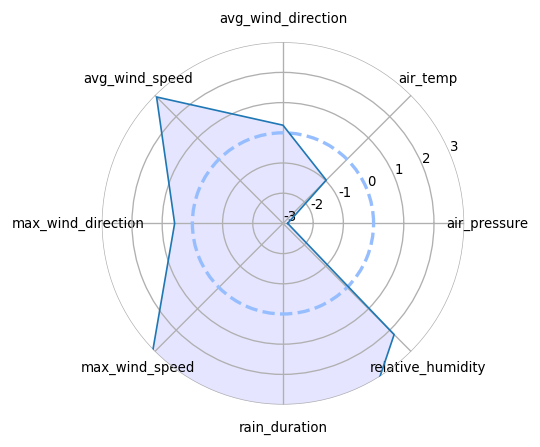

In [8]:
i = 0 # which sample in sorted df to select

# Get a list of floats from the Series and repeat last element to close the radial plot
values = weather_df.iloc[i].values.flatten().tolist()
values += values[:1]

# Get feature names as a list of strings 
features = [f.replace('_9am', '') for f in list(weather_df)]

plot_sample(values=values, feature_names=features)

#### 3b: Santa Ana Conditions
**Santa Ana conditions** are hot, dry, windy weather conditions that greatly increase the dangers of wildfires in Southern California. These winds typically blow towards the coast from mountain passes to the North-East.

<img src='./img/santa_ana_winds.jpg' length=300 width=300 align='left' alt_text='Santa Ana Winds'>

In [9]:
weather_df = data.copy() # work with a copy of the original dataframe, trust me.

# Print mins and maxes to check our intuition when plotting
print('In number of standard devations away from the mean:')
print('Max humidity: {}\nMin humidity: {}'.format(weather_df['relative_humidity_9am'].max(),
                                                  weather_df['relative_humidity_9am'].min()))
print('Max wind speed: {}\nMin wind speed: {}'.format(weather_df['avg_wind_speed_9am'].max(),
                                                            weather_df['avg_wind_speed_9am'].min()))
print('Max wind direction: {}\nMin wind direction: {}'.format(weather_df['relative_humidity_9am'].max(),
                                                              weather_df['relative_humidity_9am'].min()))

# sort weather data to put Santa Ana-like samples at the top 
# weather_df = weather_df.sort_values(['relative_humidity_9am',
#                                      'avg_wind_speed_9am',
#                                      'avg_wind_direction_9am'],
#                                     ascending=[True, False, False],
#                                     inplace=False)
weather_df = weather_df.sort_values(['max_wind_speed_9am','avg_wind_speed_9am','relative_humidity_9am'],
                                    ascending=[False, False, True],
                                    inplace=False)

In number of standard devations away from the mean:
Max humidity: 2.308763906584698
Min humidity: -1.1037506868337874
Max wind speed: 3.984888088236809
Min wind speed: -1.0568791564707432
Max wind direction: 2.308763906584698
Min wind direction: -1.1037506868337874


In [10]:
weather_df.head()

,air_pressure_9am,air_temp_9am,avg_wind_direction_9am,avg_wind_speed_9am,max_wind_direction_9am,max_wind_speed_9am,rain_duration_9am,relative_humidity_9am
number,,,,,,,,
97,0.829439,-1.957606,-1.298734,3.984888,-1.198429,4.085481,-0.110701,-0.579628
496,0.338934,-0.083319,-1.306378,3.662191,-1.118734,3.673067,-0.093997,-0.845156
912,0.313560,0.489020,-1.391287,3.432366,-1.243102,3.541329,-0.155941,-0.723969
577,0.368794,0.387368,-1.397506,3.445330,-1.263380,3.516477,-0.154511,-0.741587
308,0.358311,0.376621,-1.375151,3.461264,-1.254733,3.478827,-0.154456,-0.761702


In [11]:
weather_df.tail()

,air_pressure_9am,air_temp_9am,avg_wind_direction_9am,avg_wind_speed_9am,max_wind_direction_9am,max_wind_speed_9am,rain_duration_9am,relative_humidity_9am
number,,,,,,,,
1018,0.335579,-0.075090,0.624636,-1.047013,0.993517,-1.015942,-0.170577,-0.054323
1058,-0.595519,0.879062,1.628259,-1.027280,1.079885,-1.019943,-0.177230,-0.143057
265,-0.630121,0.300446,2.757696,-1.056879,-0.069696,-1.023944,-0.177230,-0.547684
981,0.030456,-0.139560,-0.669662,-1.037146,-0.647465,-1.031947,-0.177230,-0.222720
886,-0.063912,0.393927,0.271777,-1.037146,0.671873,-1.039949,-0.177230,-0.626953


[0.829439240227354, -1.9576060185180442, -1.298733784161944, 3.984888088236809, -1.1984294740003094, 4.08548101748796, -0.11070092414257529, -0.5796281981416738, 0.829439240227354]
air_pressure_9am         -0.265231
air_temp_9am              0.877450
avg_wind_direction_9am    1.862534
avg_wind_speed_9am       -0.751019
max_wind_direction_9am    2.187771
max_wind_speed_9am       -0.739865
rain_duration_9am        -0.177230
relative_humidity_9am     0.329009
Name: 0, dtype: float64
air_pressure_9am          0.829439
air_temp_9am             -1.957606
avg_wind_direction_9am   -1.298734
avg_wind_speed_9am        3.984888
max_wind_direction_9am   -1.198429
max_wind_speed_9am        4.085481
rain_duration_9am        -0.110701
relative_humidity_9am    -0.579628
Name: 97, dtype: float64


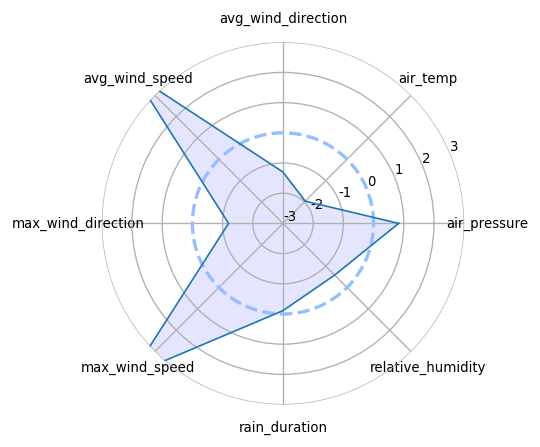

In [12]:
i = 0
values = weather_df.iloc[i].values.flatten().tolist()
values += values[:1] # must repeat last element to close the radial plot

print(values)
print(weather_df.loc[i])
print(weather_df.iloc[i])

# Get feature names as a list of strings 
features = [f.replace('_9am', '') for f in list(weather_df)]
plot_sample(values=values, feature_names=features)